### Build targets

In [3]:
def bbox_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)
    print(inter_area)
    print((b1_area + b2_area - inter_area + 1e-16))

    return iou

def build_targets(pred_boxes, pred_cls, target, anchors, ignore_thres):

    ByteTensor = torch.cuda.ByteTensor if pred_boxes.is_cuda else torch.ByteTensor
    FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

    nB = pred_boxes.size(0)
    nA = pred_boxes.size(1)
    nC = pred_cls.size(-1)
    nG = pred_boxes.size(2)

    # Output tensors
    obj_mask = ByteTensor(nB, nA, nG, nG).fill_(0)
    noobj_mask = ByteTensor(nB, nA, nG, nG).fill_(1)
    class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
    iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0)
    tx = FloatTensor(nB, nA, nG, nG).fill_(0)
    ty = FloatTensor(nB, nA, nG, nG).fill_(0)
    tw = FloatTensor(nB, nA, nG, nG).fill_(0)
    th = FloatTensor(nB, nA, nG, nG).fill_(0)
    tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)
    
    print(f'noobj_mask {noobj_mask.shape}')

    # Convert to position relative to box
    target_boxes = target[:, 2:6] * nG
    print(f'nG {nG}')
    gxy = target_boxes[:, :2]
    gwh = target_boxes[:, 2:]
    print(f'gwh {gwh}')
    # Get anchors with best iou
    ious = torch.stack([bbox_wh_iou(anchor, gwh) for anchor in anchors])
    print('anchors', anchors)
    print('ious', ious)
    best_ious, best_n = ious.max(0)
    print('best_n', best_n)
    # Separate target values
    b, target_labels = target[:, :2].long().t()
    print('b', b)
    gx, gy = gxy.t()
    gw, gh = gwh.t()
    print(f'gx, gy, gw, gh {gx} {gy} {gw} {gh}')
    gi, gj = gxy.long().t()
    print(f'gi gj {gi} {gj}')
    # Set masks
    obj_mask[b, best_n, gj, gi] = 1
    noobj_mask[b, best_n, gj, gi] = 0

    # Set noobj mask to zero where iou exceeds ignore threshold
    for i, anchor_ious in enumerate(ious.t()):
#         print('anchor_ious > ignore_thres', anchor_ious > ignore_thres)
        noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0

    # Coordinates
    tx[b, best_n, gj, gi] = gx - gx.floor()
    ty[b, best_n, gj, gi] = gy - gy.floor()
    # Width and height
    tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
    th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 1] + 1e-16)
    # One-hot encoding of label
    tcls[b, best_n, gj, gi, target_labels] = 1
    # Compute label correctness and iou at best anchor
    class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
    iou_scores[b, best_n, gj, gi] = bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False)
    print()
    print('b, best_n, gj, gi', b, best_n, gj, gi)
    print()
    print('bbox_iou', bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False))
    print()
    print('target_boxes', target_boxes)
    print()
    print(pred_boxes[b, best_n, gj, gi])

    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls


In [1]:
import torch

from utils import iou_vectorized

import numpy as np
from darknet import Darknet


anchors = torch.tensor([
    [ 3.6250,  2.8125],
    [ 4.8750,  6.1875],
    [11.6562, 10.1875]
]).float()

ignore_thresh = 0.5
B = 3
H, W = 13, 13
classes = 80
P = len(anchors) * (H * W)
device = torch.device('cpu')
num_anchs = len(anchors)

target = torch.tensor([
    [ 0.0000, 37.0000,  0.3425,  0.7006,  0.2527,  0.0898],
    [ 0.0000,  0.0000,  0.4857,  0.4737,  0.6151,  0.4413],
    [ 1.0000, 62.0000,  0.6833,  0.2446,  0.4339,  0.1869],
    [ 1.0000, 14.0000,  0.7664,  0.5047,  0.1376,  0.1346],
    [ 1.0000, 57.0000,  0.1318,  0.3852,  0.2636,  0.4733],
    [ 1.0000,  0.0000,  0.4073,  0.5028,  0.4478,  0.6808],
    [ 1.0000,  0.0000,  0.4967,  0.5625,  0.2727,  0.3840],
    [ 2.0000, 10.0000,  0.2710,  0.6109,  0.4810,  0.5519],
    [ 2.0000,  0.0000,  0.6921,  0.4621,  0.5748,  0.6939]
]).float()

seed = np.random.RandomState(13)

x = torch.tensor(seed.rand(B, P, classes + 5)).float()
a = Darknet.make_targets(x, target, anchors, ignore_thresh, device)

In [2]:
# reshape tensors so that it is easier to use them in building targets
x = x.view(B, W, H, num_anchs, classes + 5)
x = x.permute(0, 3, 1, 2, 4).contiguous() # -> (B, A, w, h, 5+classes)
b = build_targets(x[..., :4], x[..., 5:], target, anchors, ignore_thresh);

NameError: name 'build_targets' is not defined

In [5]:
((b[0][1][1] - a[0][1][1]) > 1e-6).sum()

tensor(0)

In [16]:
# noobj_mask torch.Size([3, 3, 13, 13])
# nG 13
# gwh tensor([[3.2851, 1.1674],
#         [7.9963, 5.7369],
#         [5.6407, 2.4297],
#         [1.7888, 1.7498],
#         [3.4268, 6.1529],
#         [5.8214, 8.8504],
#         [3.5451, 4.9920],
#         [6.2530, 7.1747],
#         [7.4724, 9.0207]])
# anchors tensor([[ 3.6250,  2.8125],
#         [ 4.8750,  6.1875],
#         [11.6562, 10.1875]])
# ious tensor([[0.3762, 0.2222, 0.5836, 0.3070, 0.4453, 0.1979, 0.5563, 0.2273, 0.1513],
#         [0.1271, 0.5818, 0.3699, 0.1038, 0.6990, 0.5855, 0.5867, 0.6724, 0.4475],
#         [0.0323, 0.3863, 0.1154, 0.0264, 0.1776, 0.4339, 0.1490, 0.3778, 0.5676]])
# best_n tensor([0, 1, 0, 0, 1, 1, 1, 1, 2])
# b tensor([0, 0, 1, 1, 1, 1, 1, 2, 2])
# gx, gy, gw, gh tensor([4.4525, 6.3141, 8.8829, 9.9632, 1.7134, 5.2949, 6.4571, 3.5230, 8.9973]) tensor([9.1078, 6.1581, 3.1798, 6.5611, 5.0076, 6.5364, 7.3125, 7.9417, 6.0073]) tensor([3.2851, 7.9963, 5.6407, 1.7888, 3.4268, 5.8214, 3.5451, 6.2530, 7.4724]) tensor([1.1674, 5.7369, 2.4297, 1.7498, 6.1529, 8.8504, 4.9920, 7.1747, 9.0207])
# gi gj tensor([4, 6, 8, 9, 1, 5, 6, 3, 8]) tensor([9, 6, 3, 6, 5, 6, 7, 7, 6])

In [9]:
# targets tensor([[ 0.0000, 37.0000,  0.3425,  0.7006,  0.2527,  0.0898],
#         [ 0.0000,  0.0000,  0.4857,  0.4737,  0.6151,  0.4413],
#         [ 1.0000, 62.0000,  0.6833,  0.2446,  0.4339,  0.1869],
#         [ 1.0000, 14.0000,  0.7664,  0.5047,  0.1376,  0.1346],
#         [ 1.0000, 57.0000,  0.1318,  0.3852,  0.2636,  0.4733],
#         [ 1.0000,  0.0000,  0.4073,  0.5028,  0.4478,  0.6808],
#         [ 1.0000,  0.0000,  0.4967,  0.5625,  0.2727,  0.3840],
#         [ 2.0000, 10.0000,  0.2710,  0.6109,  0.4810,  0.5519],
#         [ 2.0000,  0.0000,  0.6921,  0.4621,  0.5748,  0.6939]]) torch.Size([9, 6])
# nG 13
# anchors tensor([[ 3.6250,  2.8125],
#         [ 4.8750,  6.1875],
#         [11.6562, 10.1875]])
# ious tensor([[0.3762, 0.2222, 0.5835, 0.3070, 0.4453, 0.1979, 0.5563, 0.2272, 0.1512],
#         [0.1272, 0.5818, 0.3698, 0.1038, 0.6989, 0.5855, 0.5866, 0.6723, 0.4475],
#         [0.0323, 0.3863, 0.1154, 0.0264, 0.1775, 0.4339, 0.1490, 0.3778, 0.5677]])
# best_n tensor([0, 1, 0, 0, 1, 1, 1, 1, 2])
# b tensor([0, 0, 1, 1, 1, 1, 1, 2, 2])
# gx, gy, gw, gh tensor([4.4524, 6.3144, 8.8828, 9.9628, 1.7132, 5.2944, 6.4567, 3.5230, 8.9975]) tensor([9.1077, 6.1582, 3.1804, 6.5609, 5.0079, 6.5359, 7.3122, 7.9422, 6.0071]) tensor([3.2851, 7.9960, 5.6406, 1.7889, 3.4263, 5.8210, 3.5445, 6.2534, 7.4728]) tensor([1.1677, 5.7374, 2.4292, 1.7497, 6.1533, 8.8508, 4.9922, 7.1744, 9.0206])
# gi gj tensor([4, 6, 8, 9, 1, 5, 6, 3, 8]) tensor([9, 6, 3, 6, 5, 6, 7, 7, 6])
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 1, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([1, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 1, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 1, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([1, 1, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 1, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 1], dtype=torch.uint8)
# nG 26
# anchors tensor([[1.8750, 3.8125],
#         [3.8750, 2.8125],
#         [3.6875, 7.4375]])
# ious tensor([[0.2417, 0.0390, 0.1304, 0.5006, 0.0848, 0.0347, 0.1010, 0.0398, 0.0265],
#         [0.5264, 0.0594, 0.1988, 0.7534, 0.1292, 0.0529, 0.1540, 0.0607, 0.0404],
#         [0.2521, 0.1495, 0.2785, 0.4565, 0.3252, 0.1331, 0.3875, 0.1528, 0.1017]])
# best_n tensor([1, 2, 2, 1, 2, 2, 2, 2, 2])
# b tensor([0, 0, 1, 1, 1, 1, 1, 2, 2])
# gx, gy, gw, gh tensor([ 8.9047, 12.6287, 17.7655, 19.9255,  3.4263, 10.5887, 12.9135,  7.0460,
#         17.9950]) tensor([18.2153, 12.3165,  6.3609, 13.1219, 10.0159, 13.0717, 14.6244, 15.8844,
#         12.0142]) tensor([ 6.5702, 15.9921, 11.2812,  3.5778,  6.8526, 11.6419,  7.0891, 12.5068,
#         14.9455]) tensor([ 2.3353, 11.4748,  4.8583,  3.4994, 12.3065, 17.7015,  9.9844, 14.3487,
#         18.0412])
# gi gj tensor([ 8, 12, 17, 19,  3, 10, 12,  7, 17]) tensor([18, 12,  6, 13, 10, 13, 14, 15, 12])
# anchor_ious > ignore_thres tensor([0, 1, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([1, 1, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# nG 52
# anchors tensor([[1.2500, 1.6250],
#         [2.0000, 3.7500],
#         [4.1250, 2.8750]])
# ious tensor([[0.0331, 0.0028, 0.0093, 0.0406, 0.0060, 0.0025, 0.0072, 0.0028, 0.0019],
#         [0.1222, 0.0102, 0.0342, 0.1498, 0.0222, 0.0091, 0.0265, 0.0104, 0.0070],
#         [0.1932, 0.0162, 0.0541, 0.2368, 0.0352, 0.0144, 0.0419, 0.0165, 0.0110]])
# best_n tensor([2, 2, 2, 2, 2, 2, 2, 2, 2])
# b tensor([0, 0, 1, 1, 1, 1, 1, 2, 2])
# gx, gy, gw, gh tensor([17.8095, 25.2574, 35.5310, 39.8511,  6.8526, 21.1774, 25.8269, 14.0920,
#         35.9901]) tensor([36.4307, 24.6329, 12.7217, 26.2438, 20.0318, 26.1434, 29.2488, 31.7688,
#         24.0285]) tensor([13.1404, 31.9842, 22.5623,  7.1557, 13.7053, 23.2838, 14.1781, 25.0136,
#         29.8911]) tensor([ 4.6706, 22.9497,  9.7167,  6.9989, 24.6131, 35.4031, 19.9688, 28.6975,
#         36.0823])
# gi gj tensor([17, 25, 35, 39,  6, 21, 25, 14, 35]) tensor([36, 24, 12, 26, 20, 26, 29, 31, 24])
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)
# anchor_ious > ignore_thres tensor([0, 0, 0], dtype=torch.uint8)

In [18]:
# tensor([[0.3762, 0.2222, 0.5835, 0.3070, 0.4453, 0.1979, 0.5563, 0.2272, 0.1512],
#         [0.1272, 0.5818, 0.3698, 0.1038, 0.6989, 0.5855, 0.5866, 0.6723, 0.4475],
#         [0.0323, 0.3863, 0.1154, 0.0264, 0.1775, 0.4339, 0.1490, 0.3778, 0.5677]])

### Prediction permutations <->

In [1]:
import torch
B, C, w, h = 1, 255, 19, 19

x = torch.arange(0, C*w*h).view((B, C, w, h))

B, C, w, h = x.size()
# read layer's info
classes = 80
num_anchs = 3
# bbox coords + obj score + class scores
num_feats = 4 + 1 + classes

## Forward
# transform the predictions
# (B, ((4+1+classes)*num_achors), Gi, Gi)
# -> (B, Gi*Gi*num_anchors, (4+1+classes), Gi, Gi)
x = x.view(B, num_anchs, num_feats, w, h)
x = x.permute(0, 3, 4, 1, 2).contiguous() # (B, w, h, num_anchs, num_feats)
x = x.view(B, h*w*num_anchs, num_feats)

## Backward
x = x.view(B, w, h, num_anchs, num_feats)
x = x.permute(0, 3, 4, 1, 2).contiguous()
x = x.view(B, num_feats*num_anchs, w, h)

prediction = (
    x.view(num_samples, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
    .permute(0, 1, 3, 4, 2) # (B, A, G, G, C)
    .contiguous()
)

(x - torch.arange(0, C*w*h).view((B, C, w, h))).sum()

tensor(0)

In [1]:
import torch
B, C, w, h = 1, 255, 19, 19

x = torch.arange(0, C*w*h).view((B, C, w, h))

B, C, w, h = x.size()
# read layer's info
classes = 80
num_anchs = 3
# bbox coords + obj score + class scores
num_feats = 4 + 1 + classes

x = x.view(B, w, h, num_anchs, num_feats)
x = x.permute(0, 3, 4, 1, 2).contiguous() # -> (B, A, 5+classes, w, h)
x = x.view(B, num_feats*num_anchs, w, h) # ->  (B, A*(5+classes), w, h)
x = x.view(B, num_anchs, num_feats, w, h)
x = x.permute(0, 1, 3, 4, 2).contiguous()

a = x

In [2]:
import torch
B, C, w, h = 1, 255, 19, 19

x = torch.arange(0, C*w*h).view((B, C, w, h))

B, C, w, h = x.size()
# read layer's info
classes = 80
num_anchs = 3
# bbox coords + obj score + class scores
num_feats = 4 + 1 + classes

x = x.view(B, w, h, num_anchs, num_feats)
x = x.permute(0, 3, 1, 2, 4).contiguous()

b = x

In [3]:
(a != b).sum()

tensor(0)

In [1]:
import torch

a = torch.rand((2, 4, 6, 2))
print(a.shape)
a[:, :, :, 0].shape

torch.Size([2, 4, 6, 2])


torch.Size([2, 4, 6])

### get predictions + show

In [1]:
from matplotlib import pyplot as plt
import cv2
import torch

from darknet import Darknet
from utils import predict_and_save, scale_numbers, letterbox_pad

model = Darknet('cfg/yolov3_608x608.cfg')
weight_file = 'weights/yolov3.weights'
model.load_weights(weight_file)
model.eval();

device = torch.device('cpu')
labels_path='./data/coco.names'
# img_path = 'dog-cycle-car.png'
# img_path = 'databreakfast_spb.jpg'
img_path = 'typical_russian_morning.jpg'
save_path = './output.jpg'
show = True

img_raw = cv2.imread(img_path)
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

# add letterbox padding and save the pad sizes and scalling coefficient
# to use it latter when drawing bboxes on the original image
H, W, C = img_raw.shape
H_new, W_new, scale = scale_numbers(H, W, model.in_width)
img = cv2.resize(img_raw, (W_new, H_new))
img, pad_sizes = letterbox_pad(img)

# HWC -> CHW, scale intensities to [0, 1], send to pytorch, add 'batch-'dimension
img = img.transpose((2, 0, 1))
img = img / 255
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)

prediction = model(img, device)
# (76 x 76 + 38 x 38 + 19 x 19) * 3 = 22743
print(prediction)

we also can remove bias due to bn
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
NOTE THAT CONV BEFORE YOLO USES (num_classes filters) * num_anch
changing predictions in the nms loop make sure that it is not used later
not adding +1 in nms
loss: w and h aren"t put through sqroot
tensor([[ 3.6250,  2.8125],
        [ 4.8750,  6.1875],
        [11.6562, 10.1875]])
tensor([[1.8750, 3.8125],
        [3.8750, 2.8125],
        [3.6875, 7.4375]])


/home/vladimir/miniconda3/envs/proj/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/vladimir/miniconda3/envs/proj/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor([[1.2500, 1.6250],
        [2.0000, 3.7500],
        [4.1250, 2.8750]])
(tensor([[[1.9719e+01, 1.0263e+01, 7.9282e+01,  ..., 1.3986e-04,
          1.8127e-04, 7.4735e-05],
         [1.9255e+01, 1.3562e+01, 1.0013e+02,  ..., 2.5689e-05,
          1.5110e-04, 2.1455e-04],
         [2.1229e+01, 1.0923e+01, 4.6733e+02,  ..., 1.2822e-03,
          1.7602e-03, 9.2606e-04],
         ...,
         [6.0459e+02, 6.0341e+02, 2.8648e+00,  ..., 4.5094e-06,
          9.5747e-06, 5.3152e-06],
         [6.0322e+02, 6.0237e+02, 7.7911e+00,  ..., 4.7592e-05,
          8.4788e-05, 6.8429e-05],
         [6.0334e+02, 6.0517e+02, 5.2627e+01,  ..., 1.6760e-05,
          3.3587e-05, 4.6258e-05]]], grad_fn=<CatBackward>), 0)


tensor([[ 3.6250,  2.8125],
        [ 4.8750,  6.1875],
        [11.6562, 10.1875]])
tensor([[1.8750, 3.8125],
        [3.8750, 2.8125],
        [3.6875, 7.4375]])
tensor([[1.2500, 1.6250],
        [2.0000, 3.7500],
        [4.1250, 2.8750]])


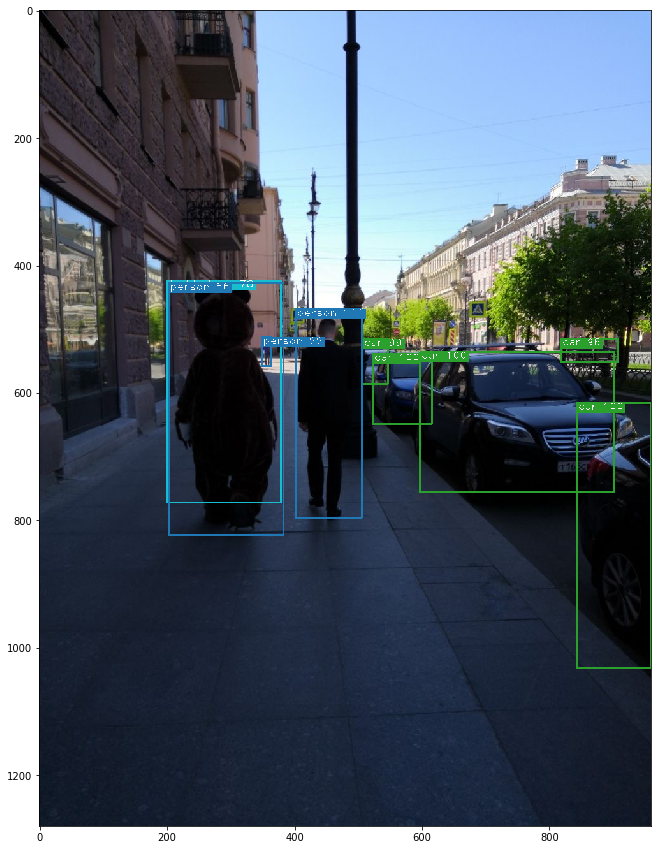

In [2]:
prediction = predict_and_save(img_path, save_path, model, device, labels_path, show)

### Dataset + show examples with bboxes

In [21]:
import cv2 
from matplotlib import pyplot as plt
from dataset import WIDERdataset

torch.Size([1, 2]) torch.Size([1, 10])


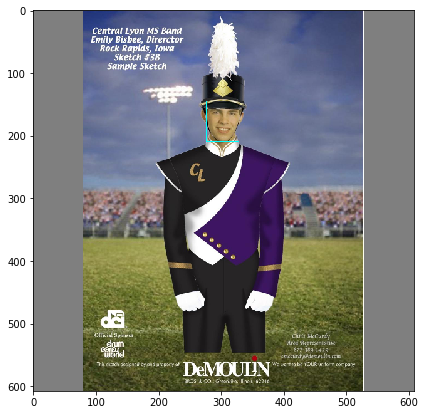

In [22]:
# train
train_dataset = WIDERdataset('./data/train.json', 'train', 608)

img, targets = train_dataset.__getitem__(0)

for target in targets:
    H, W, C = img.shape
    top_left_x = int(target[2] * W) - int((target[4] * W) // 2)
    top_left_y = int(target[3] * H) - int((target[5] * H) // 2)
    bottom_right_x = int(target[2] * W) + int((target[4] * W) // 2)
    bottom_right_y = int(target[3] * H) + int((target[5] * H) // 2)

    top_left_coords = top_left_x, top_left_y
    # top_left_coords = 100, 200
    bottom_right_coords = bottom_right_x, bottom_right_y
    # bottom_right_coords = 300, 400
    # print(top_left_coords, bottom_right_coords)
    cv2.rectangle(img, top_left_coords, bottom_right_coords, (0, 255, 255), 1)

plt.figure(figsize=(7, 7))
plt.imshow(img)